In [ ]:
<font size="+3">SQL: EARTHQUAKE DAMAGE</font>

In [2]:
# imports
import sqlite3
import warnings
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

warnings.simplefilter(action="ignore")

In [35]:
# Data Preparation
def dataWrangle(path_to_db):
    """Query a sqlite db and return a df"""

    # Connect to sqlite3 db
    conn = sqlite3.connect(path_to_db)
    query = """
        SELECT building_id, count_floors_pre_eq,
               count_floors_post_eq, age_building,
               plinth_area_sq_ft, height_ft_pre_eq,
               height_ft_post_eq, land_surface_condition,
               foundation_type, roof_type, ground_floor_type,
               other_floor_type, position, plan_configuration, vdcmun_id,
               condition_post_eq, damage_grade, technical_solution_proposed,
               superstructure
        FROM building_structure
        WHERE district_id = 28
        """
    # Convert query to a df
    df = pd.read_sql(query, conn, index_col="building_id")

    # Recast numeric columns to type int
    num_cols = ["count_floors_pre_eq", "age_building", "plinth_area_sq_ft", 
                "height_ft_pre_eq"]
    for col in num_cols:
        df[col] = df[col].astype(int)
    
    # Drop leaky columns
    for col in df.columns:
        if "post" in col:
            df.drop(columns=col, inplace=True)

    # Create binary target: binary encoding
    df["severe_damage"] = df["damage_grade"].str[-1].astype(int).apply(
        lambda x: 1 if (x > 3) else 0
    )

    # Drop other unwanted columns
    df.drop(columns=["damage_grade", "height_ft_pre_eq",
                    "technical_solution_proposed"], inplace=True)
    
    return df

In [36]:
df = dataWrangle("../Nepal2015.db")
print(df.shape)
print()
print(df.info())
print()
df.head()

(77148, 13)

<class 'pandas.core.frame.DataFrame'>
Index: 77148 entries, 280102000961 to 286209000691
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   count_floors_pre_eq     77148 non-null  int64 
 1   age_building            77148 non-null  int64 
 2   plinth_area_sq_ft       77148 non-null  int64 
 3   land_surface_condition  77148 non-null  object
 4   foundation_type         77148 non-null  object
 5   roof_type               77148 non-null  object
 6   ground_floor_type       77148 non-null  object
 7   other_floor_type        77148 non-null  object
 8   position                77148 non-null  object
 9   plan_configuration      77148 non-null  object
 10  vdcmun_id               77148 non-null  object
 11  superstructure          77148 non-null  object
 12  severe_damage           77148 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 8.2+ MB
None



count_floors_pre_eq  age_building  plinth_area_sq_ft  \
building_id                                                          
280102000961                    2             7                200   
280101000011                    2            18                450   
280101000021                    2            20                500   
280101000031                    3            21                350   
280101000041                    3            20                280   

             land_surface_condition         foundation_type  \
building_id                                                   
280102000961                   Flat  Mud mortar-Stone/Brick   
280101000011         Moderate slope  Mud mortar-Stone/Brick   
280101000021         Moderate slope  Mud mortar-Stone/Brick   
280101000031         Moderate slope  Mud mortar-Stone/Brick   
280101000041         Moderate slope  Mud mortar-Stone/Brick   

                             roof_type ground_floor_type   other_floor_type  \
building_id                                                                   
280102000961  Bamboo/Timber-Light roof               Mud  TImber/Bamboo-Mud   
280101000011  Bamboo/Timber-Light roof               Mud      Timber-Planck   
280101000021  Bamboo/Timber-Light roof               Mud      Timber-Planck   
280101000031  Bamboo/Timber-Light roof               Mud      Timber-Planck   
280101000041  Bamboo/Timber-Light roof               Mud  TImber/Bamboo-Mud   

                     position plan_configuration vdcmun_id  \
building_id                                                  
280102000961     Not attached        Rectangular      2811   
280101000011     Not attached        Rectangular      2811   
280101000021     Not attached        Rectangular      2811   
280101000031     Not attached        Rectangular      2811   
280101000041  Attached-1 side        Rectangular      2811   

                                   superstructure  severe_damage  
building_id                                                       
280102000961  has_superstructure_mud_mortar_stone              1  
280101000011  has_superstructure_mud_mortar_stone              0  
280101000021  has_superstructure_mud_mortar_stone              1  
280101000031  has_superstructure_mud_mortar_stone              0  
280101000041  has_superstructure_mud_mortar_stone              1

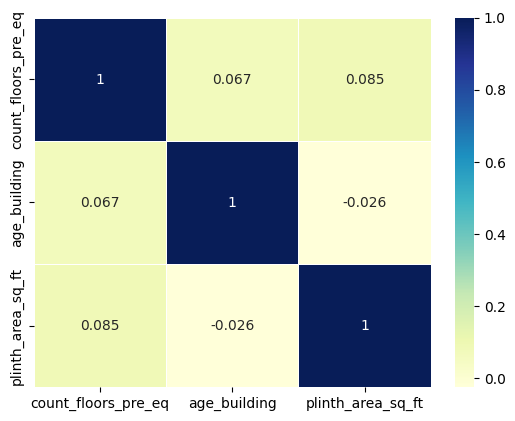

In [5]:
# Explore
# Check for multicolinearity: heatmap
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()
sns.heatmap(
    correlation,
    linewidths=0.4,
    annot=True,
    cmap="YlGnBu"
);

In [6]:
# Deteremine which multicollinear feature to drop: the one with 
# less predictive power for our target
# print(df["severe_damage"].corr(df["height_ft_pre_eq"]))
print(df["severe_damage"].corr(df["count_floors_pre_eq"]))

0.08275095140826659


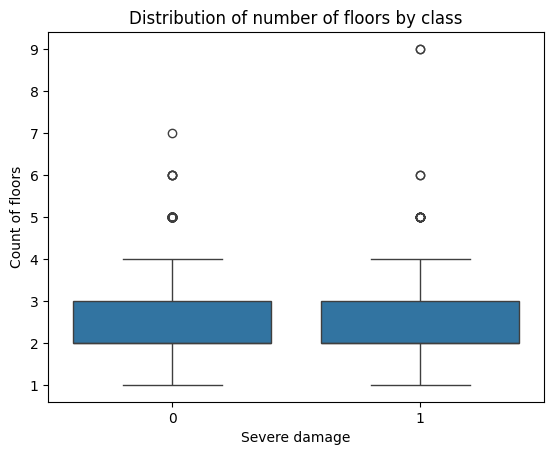

In [7]:
# Boxplot
sns.boxplot(data=df, x="severe_damage", y="count_floors_pre_eq")
plt.xlabel("Severe damage")
plt.ylabel("Count of floors")
plt.title("Distribution of number of floors by class");

# No quite difference btwn the 2 classes

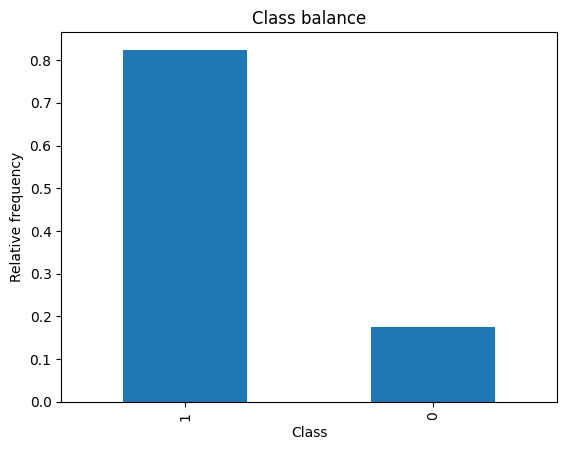

In [8]:
# Check for proportion --> class balance: bar chart
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative frequency",
    title="Class balance"
);

In [9]:
majority_class, minority_class = df["severe_damage"].value_counts(normalize=True)
print(majority_class, minority_class)

0.8241172810701509 0.1758827189298491


In [10]:
foundatn_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage",
    aggfunc=np.mean
).sort_values(by="severe_damage")
foundatn_pivot

severe_damage
foundation_type                      
RC                           0.050481
Other                        0.247863
Bamboo/Timber                0.454545
Cement-Stone/Brick           0.593092
Mud mortar-Stone/Brick       0.866976

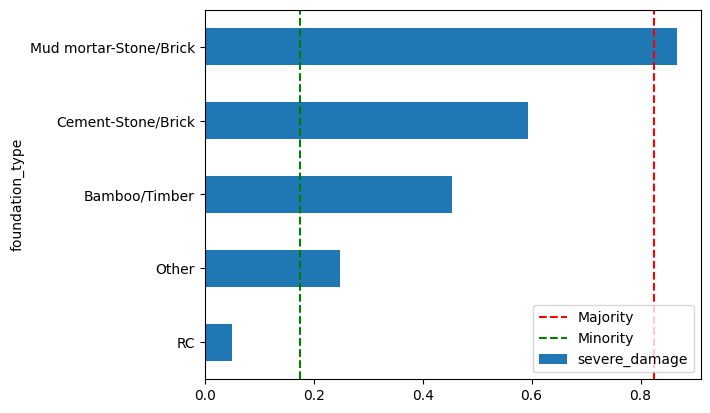

In [11]:
foundatn_pivot.plot(kind="barh")
plt.axvline(
    majority_class, linestyle="--", color="r", label="Majority"
);
plt.axvline(
    minority_class, linestyle="--", color="g", label="Minority"
)
plt.legend(loc="lower right");

In [12]:
# Check for high n low cardinality
# df.select_dtypes("object").nunique()

In [38]:
# Split: vertical --> features n target
X = df.drop(columns=["severe_damage", "vdcmun_id"], axis=1)
y = df["severe_damage"]

# Horizontal split
# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Training and validation
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42
# )

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (61718, 11)
y_train shape: (61718,)
X_val shape: (12344, 11)
y_val shape: (12344,)
X_test shape: (15430, 11)
y_test shape: (15430,)


In [39]:
# Baseline: always guessing majority class
baseline = y_train.value_counts(normalize=True).max()
round(baseline, 2)

0.82

In [40]:
# Model building 
# 1. Logistic regression
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)

# 2. Decision trees
# model = make_pipeline(
#     OrdinalEncoder(),
#     DecisionTreeClassifier(max_depth=3, random_state=42)
# )

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [41]:
# Validation
print(accuracy_score(y_train, model.predict(X_train)))
# Method 2
print(model.score(X_test, y_test))

0.8711721053825464
0.8696694750486066


In [17]:
# Tuning hyperparameters
# Get depth
# print("Tree depth: ", model.named_steps["decisiontreeclassifier"].get_depth())

# # Tuning
# depth_hyperparams = range(1, 50, 2)
# train_acc = []
# val_acc = []
# for d in depth_hyperparams:
#     # Build model
#     test_model = make_pipeline(
#         OrdinalEncoder(),
#         DecisionTreeClassifier(max_depth=d, random_state=42)
#     )
#     # Fit to training data
#     test_model.fit(X_train, y_train)
#     # Calculate train_acc
#     train_acc.append(test_model.score(X_train, y_train))
#     #Calculate val acc
#     val_acc.append(test_model.score(X_val, y_val))

# print("Training Accuracy Scores:", train_acc[:3])
# print("Validation Accuracy Scores:", val_acc[:3])

Tree depth:  3
Training Accuracy Scores: [0.8628022846032325, 0.8708429537813424, 0.8716328431968242]
Validation Accuracy Scores: [0.8610661049902787, 0.8674659753726507, 0.8670609202851588]


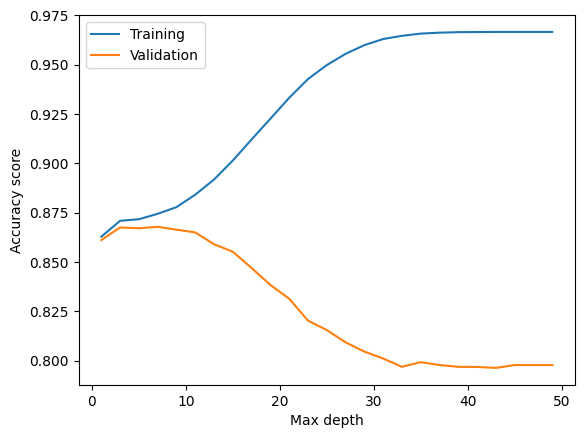

In [18]:
# Plot accuracy score --> Validation curve
# plt.plot(depth_hyperparams, train_acc, label="Training")
# plt.plot(depth_hyperparams, val_acc, label="Validation")
# plt.xlabel("Max depth")
# plt.ylabel("Accuracy score")
# plt.legend();

In [19]:
# Evaluate --> accuracy score
# Method 2
# print(model.score(X_test, y_test))

0.8705119896305897


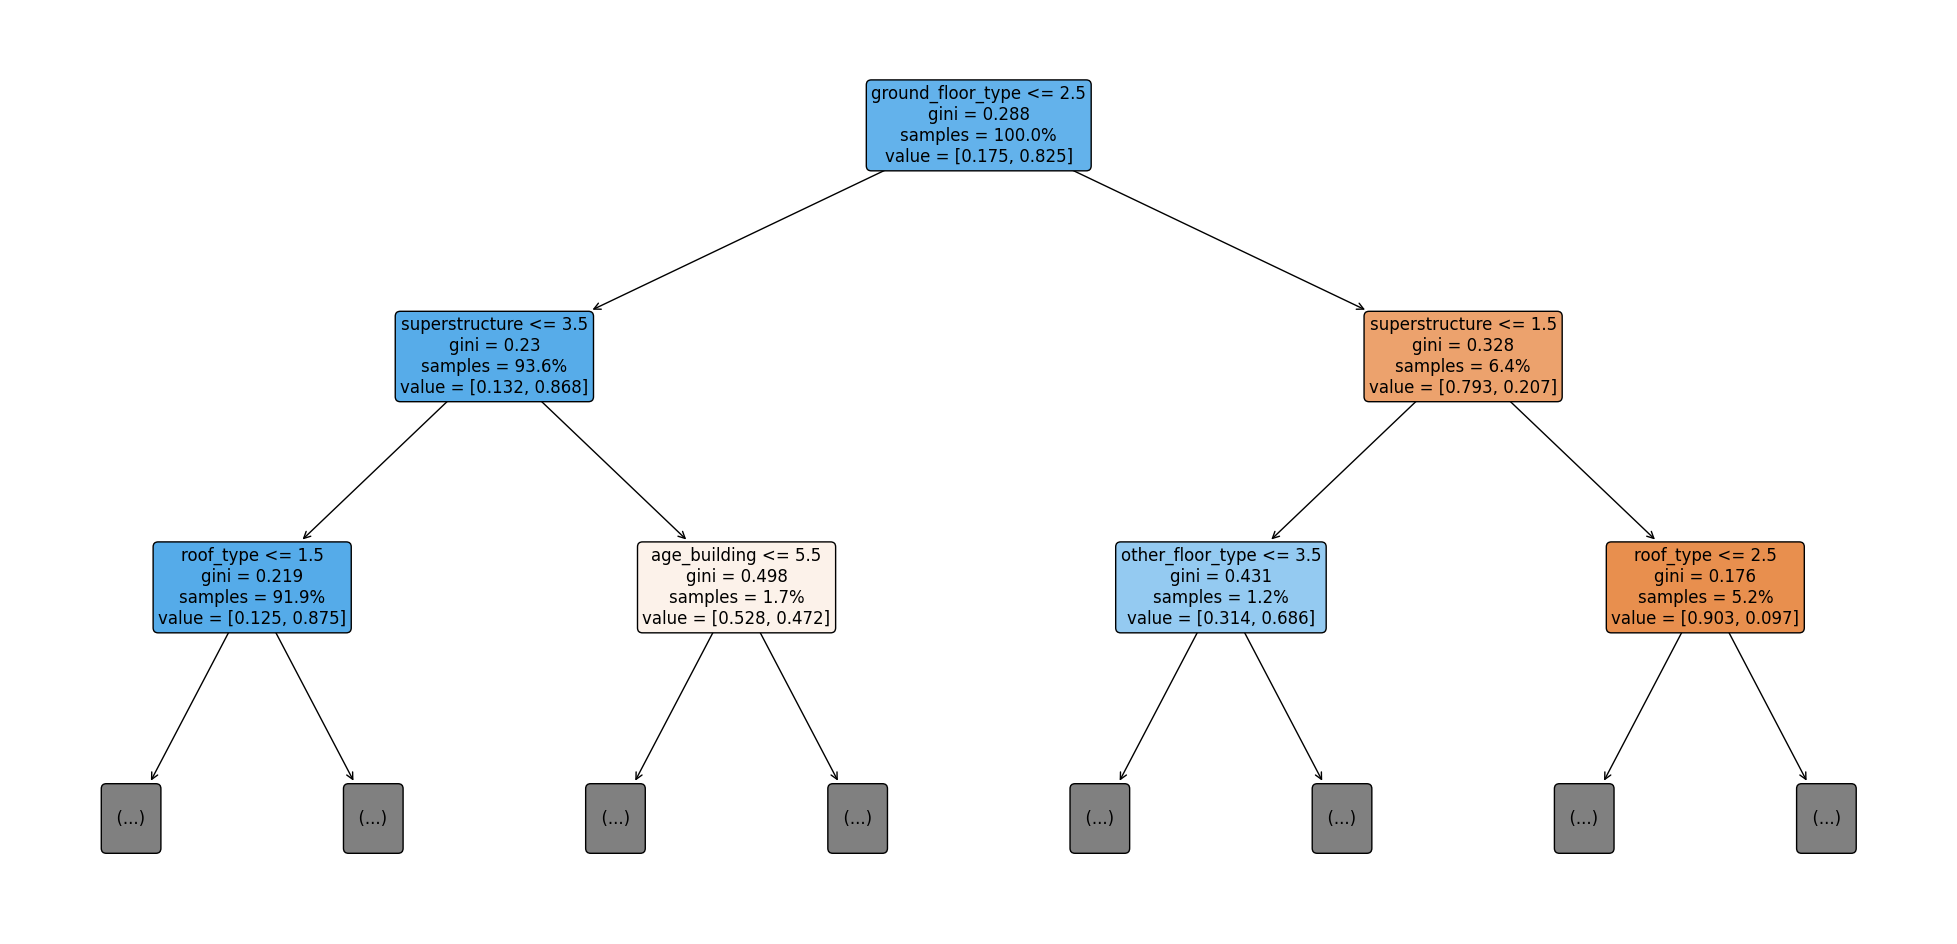

In [20]:
# Communicate
# Create larger figure
# fig, ax = plt.subplots(figsize=(25, 12))
# # Plot tree
# plot_tree(
#     decision_tree=model.named_steps["decisiontreeclassifier"],
#     feature_names=X_train.columns,
#     filled=True,  # Color leaf with class
#     rounded=True,  # Round leaf edges
#     proportion=True,  # Display proportion of classes in leaf
#     max_depth=2,  # Only display first 3 levels
#     fontsize=12,  # Enlarge font
#     ax=ax,  # Place in figure axis
# );

In [21]:
# Communicate
# Check the probability
# model.predict_proba(X_train)[:5]

In [42]:
# Feature names and importances
feat = model.named_steps["onehotencoder"].get_feature_names()
# feat = X_train.columns
importances = model.named_steps["logisticregression"].coef_[0]
# importances = model.named_steps["decisiontreeclassifier"].feature_importances_
odds_ratio = pd.Series(np.exp(importances), index=feat).sort_values()
odds_ratio.head()

superstructure_has_superstructure_cement_mortar_brick    0.342393
foundation_type_RC                                       0.442464
ground_floor_type_RC                                     0.500727
superstructure_has_superstructure_rc_non_engineered      0.517703
roof_type_RCC/RB/RBC                                     0.632027
dtype: float64

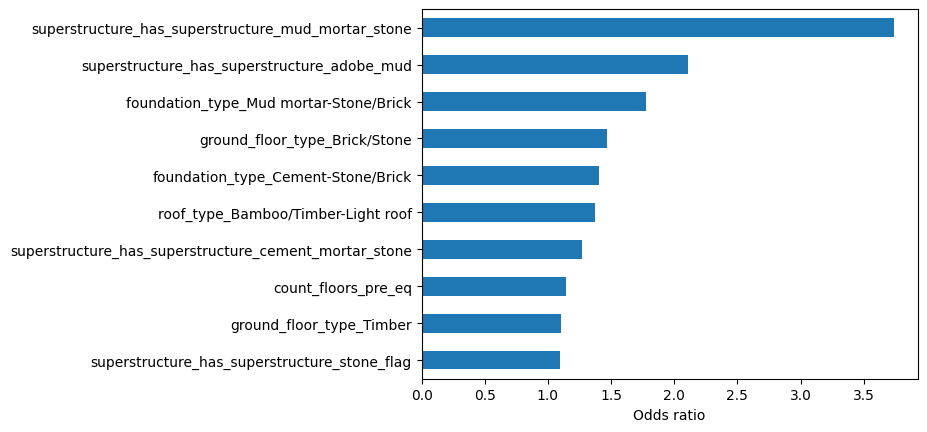

In [43]:
odds_ratio.tail(10).plot(kind="barh", xlabel="Odds ratio");

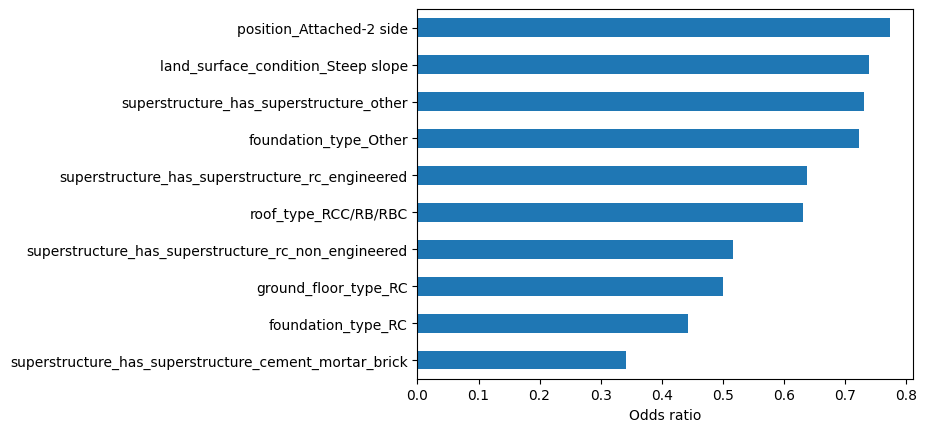

In [44]:
odds_ratio.head(10).plot(kind="barh", xlabel="Odds ratio");

In [23]:
# feat_imp = pd.Series(importances, index=feat).sort_values()
# feat_imp.tail()

other_floor_type     0.004129
age_building         0.015567
roof_type            0.023298
superstructure       0.181591
ground_floor_type    0.775415
dtype: float64

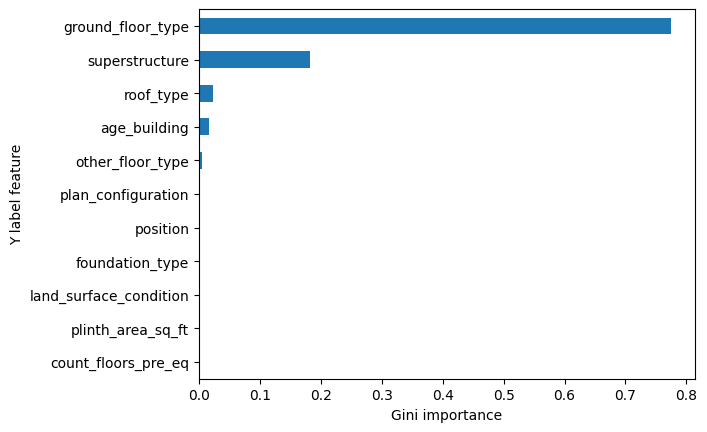

In [24]:
# How important is the feature in splitting the parent node to achieve purity
# feat_imp.plot(kind="barh", xlabel="Gini importance", ylabel="Y label feature");